In [1]:
!pip install mne torch numpy pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 100.6 MB/s eta 0:00:00


In [2]:
!pip install mne-bids

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.8/166.8 kB 10.3 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import mne
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy.signal import welch

In [4]:
import pandas as pd
import h5py

In [5]:
from mne_bids import BIDSPath, read_raw_bids

In [6]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# with open('/kaggle/input/bids-dataset/bids-dataset/derivatives/sub-001/eeg/sub-001_task-eyesclosed_eeg.set', 'rb') as f:
#     print(f.read(100))  # Read the first 100 bytes

In [8]:
def load_participant_labels(participants_file):
    """
    Load labels from the participants.tsv file.

    Args:
        participants_file (str): Path to the participants.tsv file.

    Returns:
        labels_dict (dict): Mapping of participant IDs to their labels.
    """
    participants_df = pd.read_csv(participants_file, sep="\t")
    labels_dict = {
        row["participant_id"]: row["Group"]  # Map participant ID to diagnosis group
        for _, row in participants_df.iterrows()
    }
    return labels_dict

In [9]:
def load_preprocessed_eeg_bids(bids_root, participants_file):
    """
    Load EEG data and corresponding labels using BIDS and MNE.

    Args:
        bids_root (str): Root directory of the BIDS dataset.
        participants_file (str): Path to the participants.tsv file.

    Returns:
        data (list): List of EEG data arrays (NumPy arrays).
        labels (list): Corresponding labels for the EEG data.
    """
    labels_dict = load_participant_labels(participants_file)
    eeg_data, labels = [], []

    derivatives_dir = os.path.join(bids_root, "derivatives")

    for participant_id, label in labels_dict.items():
        # Create a BIDS path for the participant
        bids_path = BIDSPath(
            root=derivatives_dir,
            subject=participant_id.replace("sub-", ""),
            task="eyesclosed",
            suffix="eeg",
            extension=".set",
            datatype="eeg",
            check=False
        )
        try:
            # Load EEG data using MNE-BIDS
            print(bids_path)
            raw = read_raw_bids(bids_path, verbose=False)
            # data = raw.get_data()  # Extract raw EEG signals as a NumPy array
            # eeg_data.append(data)
            eeg_data.append(raw)
            labels.append(label)
        except Exception as e:
            print(f"Error loading data for {participant_id}: {e}. Skipping...")

    return eeg_data, labels

In [10]:
def preprocess_eeg_data(eeg_data):
    """
    Preprocess EEG data (e.g., bandpass filtering and normalization).

    Args:
        eeg_data (list): List of EEG data arrays (NumPy arrays).

    Returns:
        preprocessed_data (list): List of preprocessed EEG signals.
    """
    preprocessed_data = []
    for data in eeg_data:
        # Apply bandpass filtering (e.g., 1-45 Hz)
        sfreq = 256  # Replace with actual sampling frequency from your data
        filtered_data = mne.filter.filter_data(data, sfreq=sfreq, l_freq=1, h_freq=45)
        preprocessed_data.append(filtered_data)
    return preprocessed_data


In [11]:
def preprocess_raw_eeg_data(eeg_data):
  preprocessed_data = []
  for data in eeg_data:
    data.filter(0.5,45,fir_design='firwin')
    # data.notch_filter(np.arange(50, 251, 50), fir_design='firwin')
    preprocessed_data.append(data)
  return preprocessed_data

In [12]:
# "A": "Alzheimer Disease Group",
# "F": "Frontotemporal Dementia Group",
# "C": "Healthy Group"
label_map = {'A': 0, 'F': 1, 'C': 2}

In [13]:
# use MyDrive files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Example Usage in Kaggle or Google Colab
bids_root = "/content/drive/MyDrive/bids_dataset"  # Modify to dataset path in your environment
participants_file = bids_root+"/participants.tsv"
# For Google Colab, use: "/content/drive/MyDrive/bids_dataset"

In [15]:
# Load and preprocess data
eeg_data, labels = load_preprocessed_eeg_bids(bids_root, participants_file)

/content/drive/MyDrive/bids_dataset/derivatives/sub-001/eeg/sub-001_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-001_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-001/**/eeg/sub-001*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-001_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-001/**/eeg/sub-001*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any eeg.json associated with sub-001_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-001/**/eeg/sub-001*eeg.json"
  raw = read_raw_

/content/drive/MyDrive/bids_dataset/derivatives/sub-002/eeg/sub-002_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-002_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-002/**/eeg/sub-002*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-002_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-002/**/eeg/sub-002*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any eeg.json associated with sub-002_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-002/**/eeg/sub-002*eeg.json"
  raw = read_raw_

/content/drive/MyDrive/bids_dataset/derivatives/sub-003/eeg/sub-003_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-003_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-003/**/eeg/sub-003*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-003_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-003/**/eeg/sub-003*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-004/eeg/sub-004_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-004_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-004/**/eeg/sub-004*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-004_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-004/**/eeg/sub-004*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-005/eeg/sub-005_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-005_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-005/**/eeg/sub-005*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-005_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-005/**/eeg/sub-005*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any eeg.json associated with sub-005_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-005/**/eeg/sub-005*eeg.json"
  raw = read_raw_

/content/drive/MyDrive/bids_dataset/derivatives/sub-006/eeg/sub-006_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-006_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-006/**/eeg/sub-006*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-006_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-006/**/eeg/sub-006*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-007/eeg/sub-007_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-007_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-007/**/eeg/sub-007*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-007_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-007/**/eeg/sub-007*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-008/eeg/sub-008_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-008_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-008/**/eeg/sub-008*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-008_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-008/**/eeg/sub-008*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-009/eeg/sub-009_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-009_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-009/**/eeg/sub-009*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-009_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-009/**/eeg/sub-009*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-010/eeg/sub-010_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-010_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-010/**/eeg/sub-010*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-010_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-010/**/eeg/sub-010*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-011/eeg/sub-011_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-011_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-011/**/eeg/sub-011*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-011_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-011/**/eeg/sub-011*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-012/eeg/sub-012_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-012_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-012/**/eeg/sub-012*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-012_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-012/**/eeg/sub-012*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-013/eeg/sub-013_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-013_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-013/**/eeg/sub-013*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-013_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-013/**/eeg/sub-013*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-014/eeg/sub-014_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-014_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-014/**/eeg/sub-014*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-014_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-014/**/eeg/sub-014*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-015/eeg/sub-015_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-015_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-015/**/eeg/sub-015*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-015_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-015/**/eeg/sub-015*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-016/eeg/sub-016_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-016_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-016/**/eeg/sub-016*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-016_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-016/**/eeg/sub-016*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-017/eeg/sub-017_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-017_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-017/**/eeg/sub-017*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-017_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-017/**/eeg/sub-017*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-018/eeg/sub-018_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-018_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-018/**/eeg/sub-018*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-018_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-018/**/eeg/sub-018*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-019/eeg/sub-019_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-019_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-019/**/eeg/sub-019*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-019_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-019/**/eeg/sub-019*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-020/eeg/sub-020_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-020_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-020/**/eeg/sub-020*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-020_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-020/**/eeg/sub-020*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any eeg.json associated with sub-020_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-020/**/eeg/sub-020*eeg.json"
  raw = read_raw_

/content/drive/MyDrive/bids_dataset/derivatives/sub-021/eeg/sub-021_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-021_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-021/**/eeg/sub-021*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-021_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-021/**/eeg/sub-021*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-022/eeg/sub-022_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-022_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-022/**/eeg/sub-022*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-022_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-022/**/eeg/sub-022*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-023/eeg/sub-023_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-023_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-023/**/eeg/sub-023*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-023_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-023/**/eeg/sub-023*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-024/eeg/sub-024_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-024_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-024/**/eeg/sub-024*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-024_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-024/**/eeg/sub-024*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-025/eeg/sub-025_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-025_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-025/**/eeg/sub-025*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-025_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-025/**/eeg/sub-025*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-026/eeg/sub-026_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-026_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-026/**/eeg/sub-026*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-026_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-026/**/eeg/sub-026*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-027/eeg/sub-027_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-027_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-027/**/eeg/sub-027*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-027_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-027/**/eeg/sub-027*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-028/eeg/sub-028_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-028_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-028/**/eeg/sub-028*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-028_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-028/**/eeg/sub-028*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-029/eeg/sub-029_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-029_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-029/**/eeg/sub-029*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-029_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-029/**/eeg/sub-029*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-030/eeg/sub-030_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-030_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-030/**/eeg/sub-030*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-030_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-030/**/eeg/sub-030*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-031/eeg/sub-031_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-031_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-031/**/eeg/sub-031*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-031_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-031/**/eeg/sub-031*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-032/eeg/sub-032_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-032_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-032/**/eeg/sub-032*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-032_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-032/**/eeg/sub-032*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-033/eeg/sub-033_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-033_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-033/**/eeg/sub-033*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-033_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-033/**/eeg/sub-033*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-034/eeg/sub-034_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-034_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-034/**/eeg/sub-034*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-034_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-034/**/eeg/sub-034*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-035/eeg/sub-035_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-035_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-035/**/eeg/sub-035*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-035_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-035/**/eeg/sub-035*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-036/eeg/sub-036_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-036_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-036/**/eeg/sub-036*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-036_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-036/**/eeg/sub-036*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-037/eeg/sub-037_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-037_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-037/**/eeg/sub-037*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-037_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-037/**/eeg/sub-037*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any eeg.json associated with sub-037_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-037/**/eeg/sub-037*eeg.json"
  raw = read_raw_

/content/drive/MyDrive/bids_dataset/derivatives/sub-038/eeg/sub-038_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-038_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-038/**/eeg/sub-038*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-038_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-038/**/eeg/sub-038*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-039/eeg/sub-039_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-039_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-039/**/eeg/sub-039*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-039_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-039/**/eeg/sub-039*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-040/eeg/sub-040_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-040_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-040/**/eeg/sub-040*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-040_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-040/**/eeg/sub-040*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-041/eeg/sub-041_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-041_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-041/**/eeg/sub-041*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-041_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-041/**/eeg/sub-041*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-042/eeg/sub-042_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-042_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-042/**/eeg/sub-042*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-042_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-042/**/eeg/sub-042*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-043/eeg/sub-043_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-043_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-043/**/eeg/sub-043*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-043_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-043/**/eeg/sub-043*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any eeg.json associated with sub-043_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-043/**/eeg/sub-043*eeg.json"
  raw = read_raw_

/content/drive/MyDrive/bids_dataset/derivatives/sub-044/eeg/sub-044_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-044_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-044/**/eeg/sub-044*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-044_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-044/**/eeg/sub-044*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any eeg.json associated with sub-044_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-044/**/eeg/sub-044*eeg.json"
  raw = read_raw_

/content/drive/MyDrive/bids_dataset/derivatives/sub-045/eeg/sub-045_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-045_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-045/**/eeg/sub-045*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-045_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-045/**/eeg/sub-045*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-046/eeg/sub-046_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-046_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-046/**/eeg/sub-046*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-046_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-046/**/eeg/sub-046*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-047/eeg/sub-047_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-047_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-047/**/eeg/sub-047*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-047_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-047/**/eeg/sub-047*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-048/eeg/sub-048_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-048_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-048/**/eeg/sub-048*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-048_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-048/**/eeg/sub-048*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-049/eeg/sub-049_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-049_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-049/**/eeg/sub-049*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-049_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-049/**/eeg/sub-049*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-050/eeg/sub-050_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-050_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-050/**/eeg/sub-050*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-050_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-050/**/eeg/sub-050*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-051/eeg/sub-051_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-051_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-051/**/eeg/sub-051*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-051_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-051/**/eeg/sub-051*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-052/eeg/sub-052_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-052_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-052/**/eeg/sub-052*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-052_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-052/**/eeg/sub-052*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-053/eeg/sub-053_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-053_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-053/**/eeg/sub-053*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-053_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-053/**/eeg/sub-053*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-054/eeg/sub-054_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-054_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-054/**/eeg/sub-054*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-054_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-054/**/eeg/sub-054*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-055/eeg/sub-055_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-055_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-055/**/eeg/sub-055*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-055_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-055/**/eeg/sub-055*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-056/eeg/sub-056_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-056_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-056/**/eeg/sub-056*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-056_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-056/**/eeg/sub-056*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-057/eeg/sub-057_task-eyesclosed_eeg.set
Error loading data for sub-057: [Errno 2] No such file or directory: '/content/drive/MyDrive/bids_dataset/derivatives/sub-057/eeg'. Skipping...
/content/drive/MyDrive/bids_dataset/derivatives/sub-058/eeg/sub-058_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-058_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-058/**/eeg/sub-058*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-058_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-058/**/eeg/sub-058*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-059/eeg/sub-059_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-059_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-059/**/eeg/sub-059*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-059_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-059/**/eeg/sub-059*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-060/eeg/sub-060_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-060_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-060/**/eeg/sub-060*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-060_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-060/**/eeg/sub-060*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-061/eeg/sub-061_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-061_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-061/**/eeg/sub-061*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-061_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-061/**/eeg/sub-061*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-062/eeg/sub-062_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-062_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-062/**/eeg/sub-062*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-062_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-062/**/eeg/sub-062*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-063/eeg/sub-063_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-063_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-063/**/eeg/sub-063*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-063_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-063/**/eeg/sub-063*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-064/eeg/sub-064_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-064_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-064/**/eeg/sub-064*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-064_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-064/**/eeg/sub-064*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-065/eeg/sub-065_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-065_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-065/**/eeg/sub-065*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-065_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-065/**/eeg/sub-065*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any eeg.json associated with sub-065_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-065/**/eeg/sub-065*eeg.json"
  raw = read_raw_

/content/drive/MyDrive/bids_dataset/derivatives/sub-066/eeg/sub-066_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-066_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-066/**/eeg/sub-066*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-066_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-066/**/eeg/sub-066*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-067/eeg/sub-067_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-067_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-067/**/eeg/sub-067*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-067_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-067/**/eeg/sub-067*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any eeg.json associated with sub-067_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-067/**/eeg/sub-067*eeg.json"
  raw = read_raw_

/content/drive/MyDrive/bids_dataset/derivatives/sub-068/eeg/sub-068_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-068_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-068/**/eeg/sub-068*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-068_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-068/**/eeg/sub-068*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-069/eeg/sub-069_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-069_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-069/**/eeg/sub-069*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-069_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-069/**/eeg/sub-069*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-070/eeg/sub-070_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-070_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-070/**/eeg/sub-070*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-070_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-070/**/eeg/sub-070*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any eeg.json associated with sub-070_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-070/**/eeg/sub-070*eeg.json"
  raw = read_raw_

/content/drive/MyDrive/bids_dataset/derivatives/sub-071/eeg/sub-071_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-071_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-071/**/eeg/sub-071*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-071_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-071/**/eeg/sub-071*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-072/eeg/sub-072_task-eyesclosed_eeg.set
Error loading data for sub-072: could not read bytes. Skipping...
/content/drive/MyDrive/bids_dataset/derivatives/sub-073/eeg/sub-073_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-073_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-073/**/eeg/sub-073*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-073_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-073/**/eeg/sub-073*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-074/eeg/sub-074_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-074_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-074/**/eeg/sub-074*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-074_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-074/**/eeg/sub-074*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-075/eeg/sub-075_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-075_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-075/**/eeg/sub-075*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-075_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-075/**/eeg/sub-075*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-076/eeg/sub-076_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-076_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-076/**/eeg/sub-076*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-076_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-076/**/eeg/sub-076*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any eeg.json associated with sub-076_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-076/**/eeg/sub-076*eeg.json"
  raw = read_raw_

/content/drive/MyDrive/bids_dataset/derivatives/sub-077/eeg/sub-077_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-077_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-077/**/eeg/sub-077*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-077_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-077/**/eeg/sub-077*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-078/eeg/sub-078_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-078_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-078/**/eeg/sub-078*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-078_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-078/**/eeg/sub-078*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-079/eeg/sub-079_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-079_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-079/**/eeg/sub-079*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-079_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-079/**/eeg/sub-079*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-080/eeg/sub-080_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-080_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-080/**/eeg/sub-080*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-080_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-080/**/eeg/sub-080*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-081/eeg/sub-081_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-081_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-081/**/eeg/sub-081*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-081_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-081/**/eeg/sub-081*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-082/eeg/sub-082_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-082_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-082/**/eeg/sub-082*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-082_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-082/**/eeg/sub-082*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any eeg.json associated with sub-082_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-082/**/eeg/sub-082*eeg.json"
  raw = read_raw_

/content/drive/MyDrive/bids_dataset/derivatives/sub-083/eeg/sub-083_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-083_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-083/**/eeg/sub-083*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-083_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-083/**/eeg/sub-083*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any eeg.json associated with sub-083_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-083/**/eeg/sub-083*eeg.json"
  raw = read_raw_

/content/drive/MyDrive/bids_dataset/derivatives/sub-084/eeg/sub-084_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-084_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-084/**/eeg/sub-084*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-084_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-084/**/eeg/sub-084*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any eeg.json associated with sub-084_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-084/**/eeg/sub-084*eeg.json"
  raw = read_raw_

/content/drive/MyDrive/bids_dataset/derivatives/sub-085/eeg/sub-085_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-085_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-085/**/eeg/sub-085*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-085_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-085/**/eeg/sub-085*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-086/eeg/sub-086_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-086_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-086/**/eeg/sub-086*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-086_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-086/**/eeg/sub-086*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-087/eeg/sub-087_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-087_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-087/**/eeg/sub-087*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-087_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-087/**/eeg/sub-087*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

/content/drive/MyDrive/bids_dataset/derivatives/sub-088/eeg/sub-088_task-eyesclosed_eeg.set


<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any events.tsv associated with sub-088_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-088/**/eeg/sub-088*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-9-8eeb42653a54>:32: RuntimeWarning: Did not find any channels.tsv associated with sub-088_task-eyesclosed.

The search_str was "/content/drive/MyDrive/bids_dataset/derivatives/sub-088/**/eeg/sub-088*channels.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-

Using matplotlib as 2D backend.


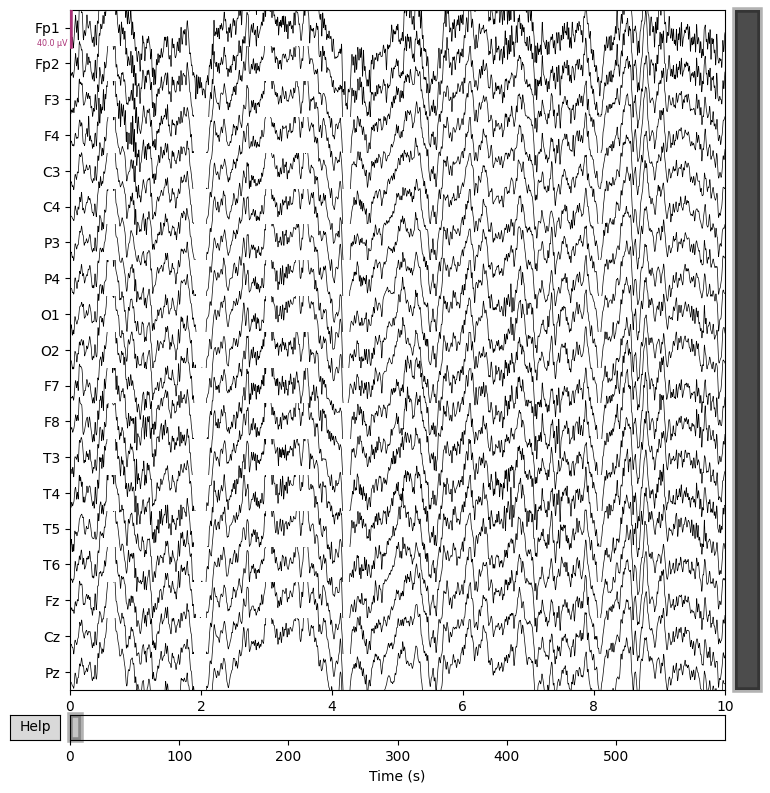

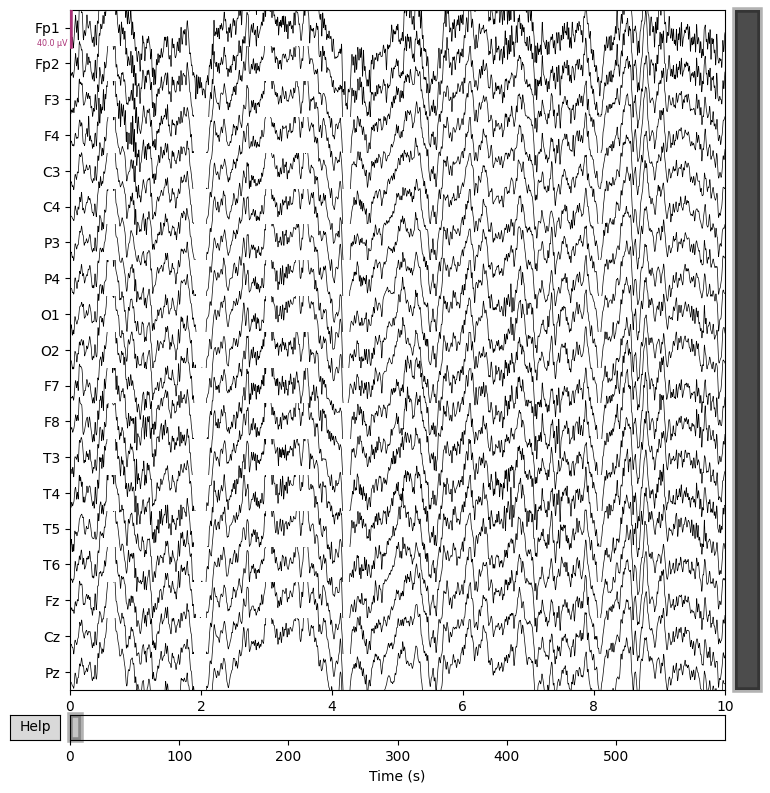

In [16]:
eeg_data[0].plot()

In [17]:
eeg_data = preprocess_raw_eeg_data(eeg_data)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


In [18]:
eeg_data[0]

<RawEEGLAB | sub-001_task-eyesclosed_eeg.set, 19 x 299900 (599.8 s), ~43.5 MB, data loaded>

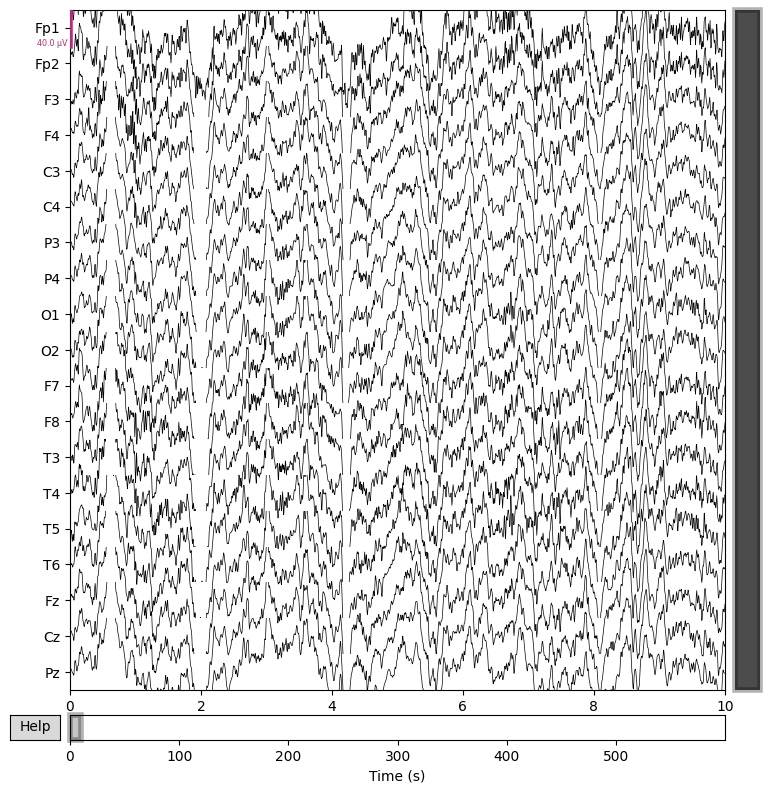

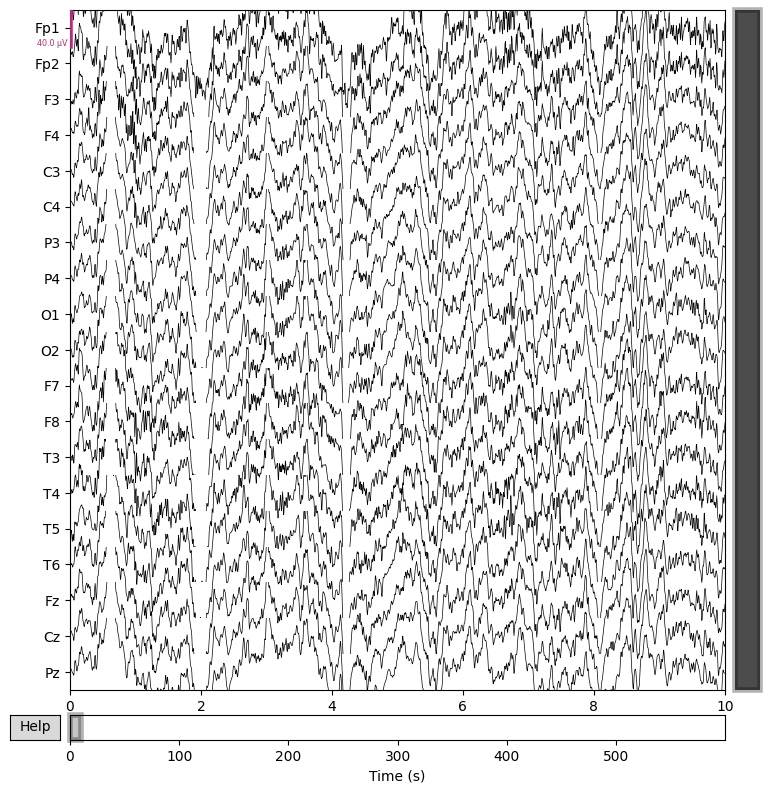

In [19]:
eeg_data[0].plot()

In [24]:
### Step 2: Epoching and Feature Extraction ###
def extract_features(raw, labels, sampling_rate=500, window_size=4):
    """Extract Relative Band Power (RBP) features from raw EEG data."""
    epochs_list = []
    labels_list = []

    freq_bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 25), 'Gamma': (25, 45)}

    for i, raw_eeg in enumerate(raw):
        # Epoching: Create 4-second windows with 50% overlap
        window_length = window_size * sampling_rate
        sfreq = raw_eeg.info['sfreq']
        n_samples = raw_eeg.n_times
        n_windows = int(np.floor(n_samples / (window_length // 2)) - 1)

        for idx in range(n_windows):
            start = idx * (window_length // 2)
            stop = start + window_length
            data = raw_eeg.get_data()[:, start:stop]

            # Compute PSD using Welch's method
            fmin, fmax = 0, 45

            # Calculate PSD for each channel individually
            psd_channels = []
            for channel_data in data:  # Iterate over channels
                psd, freqs = welch(channel_data, sfreq, nperseg=sfreq*2, nfft=sfreq*4)
                psd_channels.append(psd)

            psd = np.array(psd_channels)  # Combine PSDs of all channels into an array


            # print(psd.shape)
            # Compute RBP features for each channel
            rbp_features = []
            # print(data.shape[0])
            for channel_idx in range(data.shape[0]):  # Iterate over channels
                for band, (fmin_band, fmax_band) in freq_bands.items():
                    idx_band = np.where((freqs >= fmin_band) & (freqs < fmax_band))[0]
                    rbp = np.sum(psd[channel_idx][idx_band]) / np.sum(psd[channel_idx])  # Calculate RBP for the current channel
                    rbp_features.append(rbp)  # Append to the feature list

            epochs_list.append(rbp_features)
            labels_list.append(labels[i])

    return epochs_list, labels_list

In [25]:
# current time
import time
start_time = time.time()

In [26]:
features, labels = extract_features(eeg_data, labels)

In [27]:
end_time = time.time()

In [28]:
total_time = end_time - start_time
# in mins
print(total_time/60)

17.82824823061625


In [29]:
class EEGDataset(Dataset):
    def __init__(self, eeg_data, labels, label_map):
        """
        Initialize the dataset with EEG data and labels.

        Args:
            eeg_data (list): List of EEG signals (NumPy arrays).
            labels (list): List of corresponding labels.
            label_map (dict): Mapping of class labels to integers.
        """
        self.eeg_data = eeg_data
        self.labels = [label_map[label] for label in labels]

    def __len__(self):
        return len(self.eeg_data)

    def __getitem__(self, idx):
        return torch.tensor(self.eeg_data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)


In [30]:
# Train-test split
X_train, X_test, y_train_labels, y_test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)
train_dataset = EEGDataset(X_train, y_train_labels,label_map)
test_dataset = EEGDataset(X_test, y_test_labels,label_map)

In [31]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [32]:
### Step 4: Define the CNN + LSTM + Attention Model ###
class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(input_dim, 1)

    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        weights = torch.softmax(self.attention(x), dim=1)  # Attention weights
        context_vector = torch.sum(weights * x, dim=1)  # Weighted sum
        return context_vector, weights

In [33]:
class CNNLSTMAttention(nn.Module):
    def __init__(self, input_dim, timesteps, cnn_channels, hidden_dim, output_dim):
        super(CNNLSTMAttention, self).__init__()
        # CNN
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=cnn_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=cnn_channels, out_channels=cnn_channels * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        # LSTM
        self.lstm = nn.LSTM(cnn_channels * 2, hidden_dim, batch_first=True, bidirectional=True)
        # Attention
        self.attention = AttentionLayer(hidden_dim * 2)
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        x = self.cnn(x)  # CNN output
        x = x.permute(0, 2, 1)  # (batch_size, timesteps, channels)
        lstm_out, _ = self.lstm(x)  # LSTM output
        context_vector, attention_weights = self.attention(lstm_out)
        output = self.fc(context_vector)
        return output, attention_weights


In [34]:
# Model initialization
input_dim = 5
timesteps = 20  # Sequence length after epoching
cnn_channels = 16
hidden_dim = 64
output_dim = 3
model = CNNLSTMAttention(input_dim, timesteps, cnn_channels, hidden_dim, output_dim).to(device)

### Step 5: Train the Model ###
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [35]:
# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        # Reshape X_batch to have the correct number of channels
        # Assuming your original data has 5 features that should be treated as channels
        X_batch = X_batch.reshape(X_batch.size(0), input_dim, -1)
        outputs, _ = model(X_batch)  # Remove unsqueeze(1)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/20, Loss: 0.0326
Epoch 2/20, Loss: 0.0000
Epoch 3/20, Loss: 0.0000
Epoch 4/20, Loss: 0.0000
Epoch 5/20, Loss: 0.0000
Epoch 6/20, Loss: 0.0000
Epoch 7/20, Loss: 0.0000
Epoch 8/20, Loss: 0.0000
Epoch 9/20, Loss: 0.0000
Epoch 10/20, Loss: 0.0000
Epoch 11/20, Loss: 0.0000
Epoch 12/20, Loss: 0.0000
Epoch 13/20, Loss: 0.0000
Epoch 14/20, Loss: 0.0000
Epoch 15/20, Loss: 0.0000
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0000
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000


In [36]:
### Step 6: Evaluate the Model ###
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # Reshape X_batch similar to how you did in training
        X_batch = X_batch.reshape(X_batch.size(0), input_dim, -1)
        outputs, _ = model(X_batch)  # Remove unsqueeze(1) and pass the reshaped data
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

In [37]:
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 100.00%
